<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" width="50" height="50">

# Project 3: Ames Housing Price Prediction

In this project, you will use everything we've learned so far to predict the home prices of properties in the lovely Ames, Iowa. The Ames dataset is included in this repo as `data/ames.csv` and `data/ames_description.txt`.

To pass this project, you must use all of the best practices and stipulations outlined below. More specifically, the following best practices and instructions must be met. 

**Read the following carefully:**
* All imports must go in the first code cell of the notebook.
* As best you can, follow all coding syntax best practices used by the instructor in class. For example:
    - `snake_case` variable names.
    - Spaces around operators and after commas.
    - No cell requires you to scroll horizontally. Split up long lines of code into multiple lines.
    - No cell output is too long. If you intend on showing data, please use `.head()` or similar.
    - **THESE ARE NOT SUBJECTIVE TO THE INSTRUCTOR'S TASTES!!** We have been meticulously following the proper Python style guide called PEP8. You can read more about it [here](https://
    www.python.org/dev/peps/pep-0008/).

Also required:
* Manipulate, clean, augment, and transform data before cells involving modeling.
* Produce clean, `scikit-learn`-usable `X` and `y` objects as done in class. Our y-variable for this problem will be `SalePrice`, the sale price of a home.
* You _must_ carry out one of the model validation techniques done in class.
    - This should be done _only_ on the data contained in `ames.csv`.
* You _must_ carry out at least **TWO** types of models appropriate for this task. They do not need to be good. The quality of your model fit _will not impact your grade at all._
* For each model, calculate **THREE** different model metrics from the `sklearn.metrics` submodule. (ie, six total model metrics).
    - Built-in methods don't count. ie, `.score()` and `.oob_score_` don't satisfy this requirement.
* One of the above model metrics must be human-interpretable.
* In a few sentences, interpret the interpretable metric for each model. According to this metric, which model was better?

---

Optionally, you may submit predictions to this [Kaggle competition](https://www.kaggle.com/t/06379d0606b04d74bab15a31734d2a9f). To make a submission:
* Make a prediction for each row of `data/kaggle_test_set.csv`. 
* Upload your solutions to Kaggle in the same format as `data/kaggle_sample_submission.csv` (e.g. use `df.to_csv(..., index=False)`).

In [543]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
import seaborn as sns
sns.set()
House_raw = pd.read_csv('./data/ames.csv')
house_df = House_raw.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [544]:
for col in house_df: 
    if house_df[col].isnull().sum() > 500:
        del house_df[col]
        
house_df = house_df.dropna()
print('Original Shape:', House_raw.shape)
print('New Shape:' ,house_df.shape)
print('Null Sum:' ,house_df.isnull().sum().sum())
# 5 COLUMNS HAVE BEEN DELETED. 

Original Shape: (1460, 81)
New Shape: (1094, 76)
Null Sum: 0


In [545]:
print('Columns:', house_df.columns)
print()
print(house_df.info())

Columns: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF'

In [546]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
# populate list of Numerical and Categorial Variables
num_list = []
cat_list = []
for column in house_df: 
    if is_numeric_dtype(house_df[column]):
         num_list.append(column)
    elif is_string_dtype(house_df[column]):
         cat_list.append(column)

print("Numerical: ", num_list)
print("\n")
print("Categorical: ", cat_list)

Numerical:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Categorical:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', '

C:\Users\nhaus\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nhaus\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


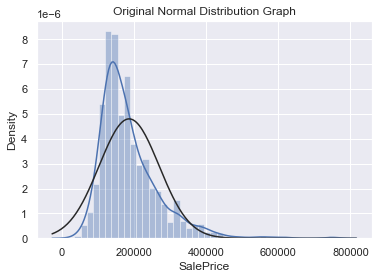

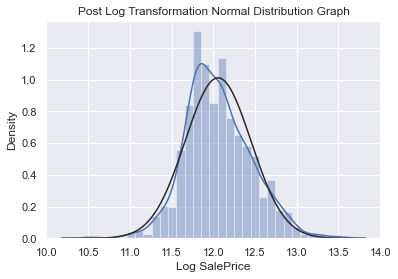

<Figure size 432x288 with 0 Axes>

In [547]:
#histogram and normal probability plot
sns.distplot(house_df['SalePrice'], fit=norm);
plt.title('Original Normal Distribution Graph')
fig = plt.figure()
print()
house_df['Log SalePrice'] = np.log(house_df['SalePrice'])
sns.distplot(house_df['Log SalePrice'], fit=norm);
plt.title('Post Log Transformation Normal Distribution Graph')
fig = plt.figure()


---
Descriptive Variables
---
Lets look at thte attributes which most likely describe the house 


In [548]:
def plot(df, columns):
    fig, axs = plt.subplots(1, len(columns), figsize=(30, 5))
    i = 0
    for col in columns: 
        if len(col) == 2:
            if df[col[1]].dtypes == 'object':
                sns.boxplot(x = col[1], y = col[0],\
                            ax = axs[i], data = df)
                           
            else:
                 df[col].plot(kind = 'scatter',\
                          x = col[0], y = col[1],\
                          ax = axs[i],\
                          color="k", \
                          alpha= 0.5)
                
        elif df[col].nunique() > 10: # if the values have more then 10 unique values , make a histogram. Too many categories. 
             df[col].plot(kind = 'hist', \
                          bins = 15,\
                          ax = axs[i])
             axs[i].set_title(col, \
                              fontsize = 14, \
                              fontweight ='bold')
             axs[i].set_ylabel('')
                
        else:    
            df.groupby(df[col]).size().plot(kind='pie',\
                                            textprops={'fontsize': 10},\
                                            ax=axs[i],\
                                            autopct='%1.0f%%')
            axs[i].set_title(col, fontsize = 14, \
                             fontweight ='bold')
            axs[i].set_ylabel('')
        i += 1
    plt.tight_layout()    
    plt.show()

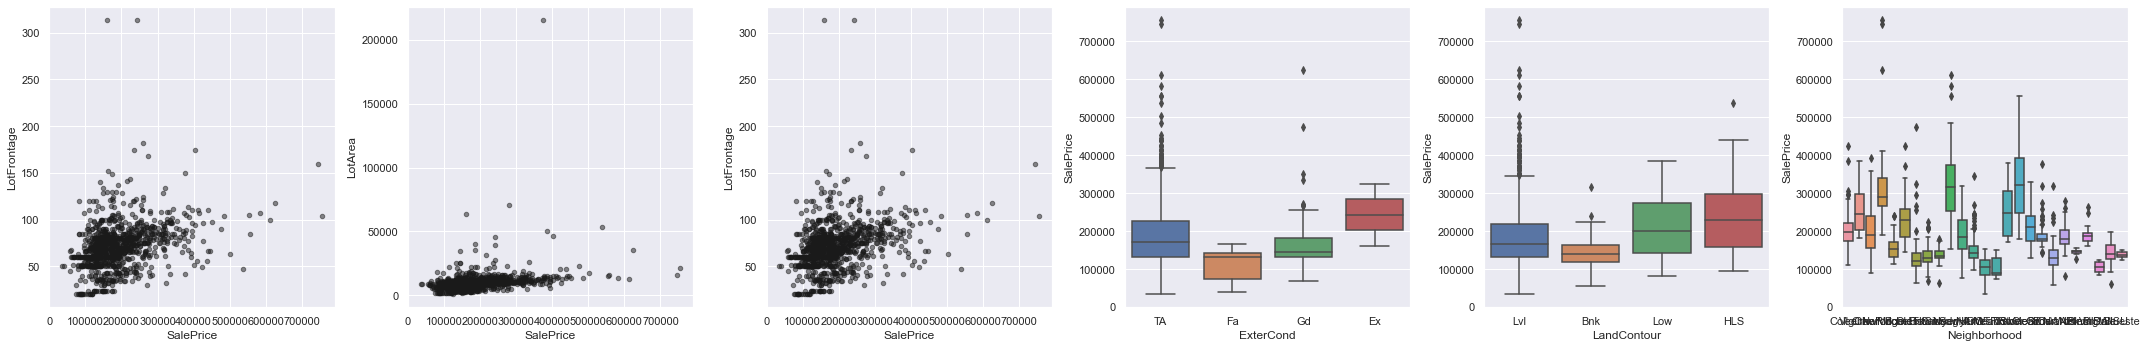

In [549]:
# Outside of the House: 


columns = [['SalePrice','LotFrontage'],['SalePrice','LotArea'],['SalePrice','LotFrontage'],\
          ['SalePrice','ExterCond'],['SalePrice','LandContour'],['SalePrice','Neighborhood']]



plot(house_df,columns)

#### OUTSIDE OF THE HOUSE:  (Key Features) 
 
It seems like not much of the house setting really effects the price in some way. **Neighborhood** is quite interesting , there are some neighborhoods which only have a smaller price range while some have greater ones.  

**Lot Area** is pretty catchy as it has a very small slope but at the same time gradually increase based off of LotArea. Usually places like farms , would be cheaper then you would expect for land. But it increases gradually as lot area increase.


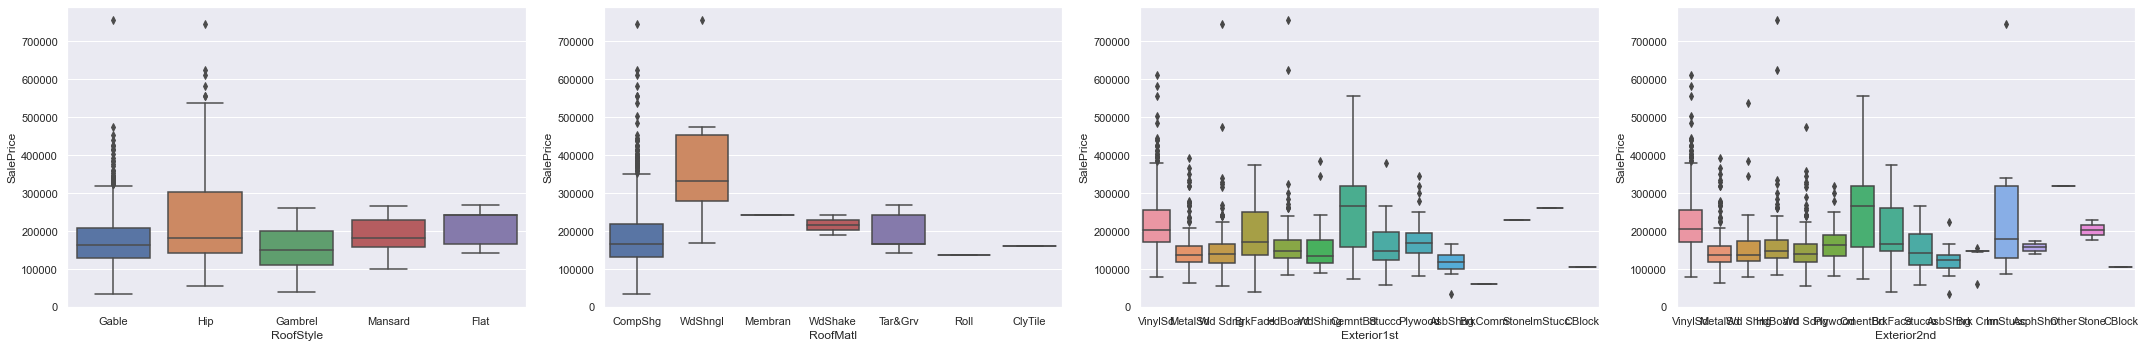

In [550]:
# Roof of the House: 


columns = [['SalePrice','RoofStyle'],['SalePrice','RoofMatl'],['SalePrice','Exterior1st'],\
          ['SalePrice','Exterior2nd']]



plot(house_df,columns)

#### ROOF: (Key Features)

It seems like the  roof tends to be not much helpful towards determining the price of the house.  We could possibly do something with roof material.
Exterior1st and Exterior2nd seem to be pretty well correlated with each other till the end.  Seems like Wind Shingels tend to increase the price of the house.


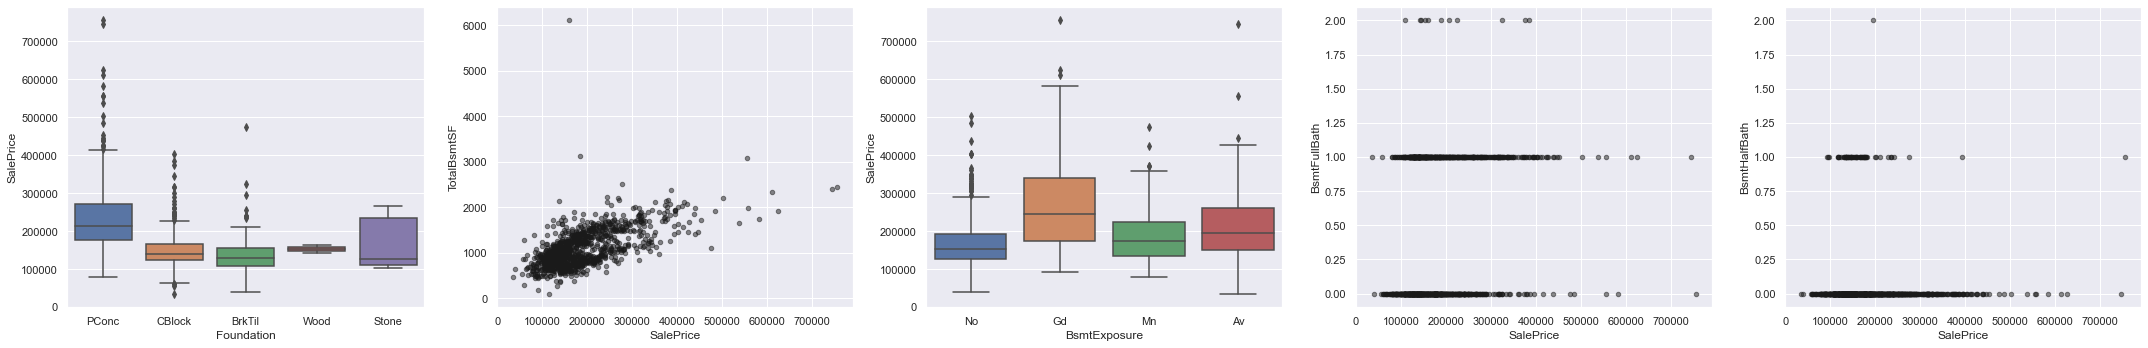

In [551]:
# Basement of the House: 

columns = [['SalePrice','Foundation'],['SalePrice','TotalBsmtSF'],['SalePrice','BsmtExposure'],\
          ['SalePrice','BsmtFullBath'], ['SalePrice','BsmtHalfBath']]



plot(house_df,columns)

#### BASEMENT Key Features

Basemet seems to have an average impact on the house price. We can see that more basement square feet could definetley mean a higher price range of the house.

Foundation seems to have a small impact on the price. Poured Concrete seems to overtake most of the houses in the data along with cinderblock. I am curious how much of each unique value there is. 


In [552]:
house_df.Foundation.value_counts() # We can see here that CinderBlock and Poured Concrete overtake much of data. We can assume that maybe a higher price
# might indicate Poured Concrete instead of CinderBlock. 

PConc     518
CBlock    446
BrkTil    122
Stone       6
Wood        2
Name: Foundation, dtype: int64

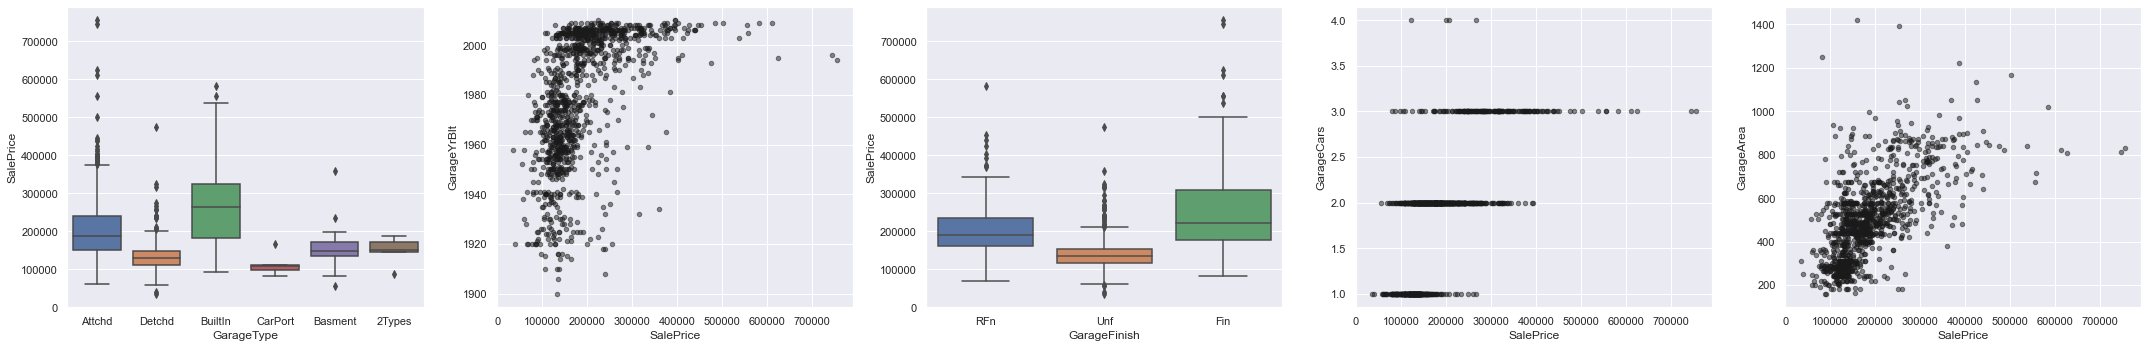

In [553]:
# Garage : 

columns = [['SalePrice','GarageType'],['SalePrice','GarageYrBlt'],['SalePrice','GarageFinish'],\
          ['SalePrice','GarageCars'], ['SalePrice','GarageArea']]



plot(house_df,columns)

#### GARAGE: (Key Features):

Garage Finish and Garage Cars seems to have the bigger spect in effect twoards the SalePrice of the houses. 

It seems like Builtin for garage types are pretty common and fall in a range of values. 

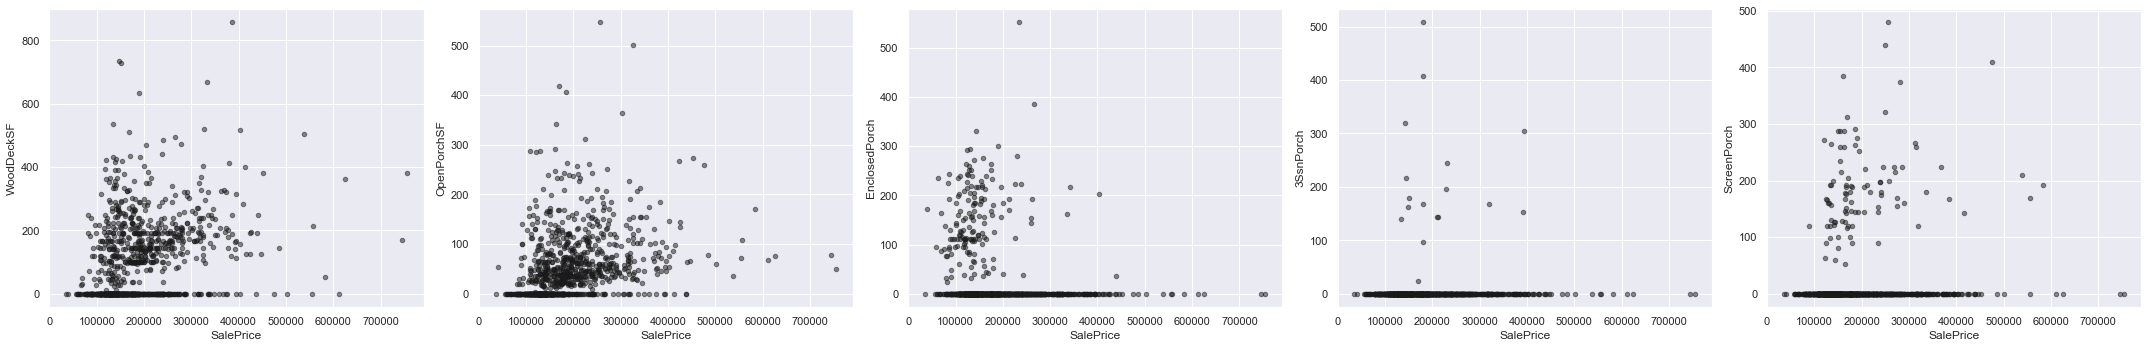

In [554]:
# Backyard : 

columns = [['SalePrice','WoodDeckSF'],['SalePrice','OpenPorchSF'],['SalePrice','EnclosedPorch'],\
          ['SalePrice','3SsnPorch'], ['SalePrice','ScreenPorch']]



plot(house_df,columns)

#### BACKYARD : (Key Features)

Seems like it does not really matter. 

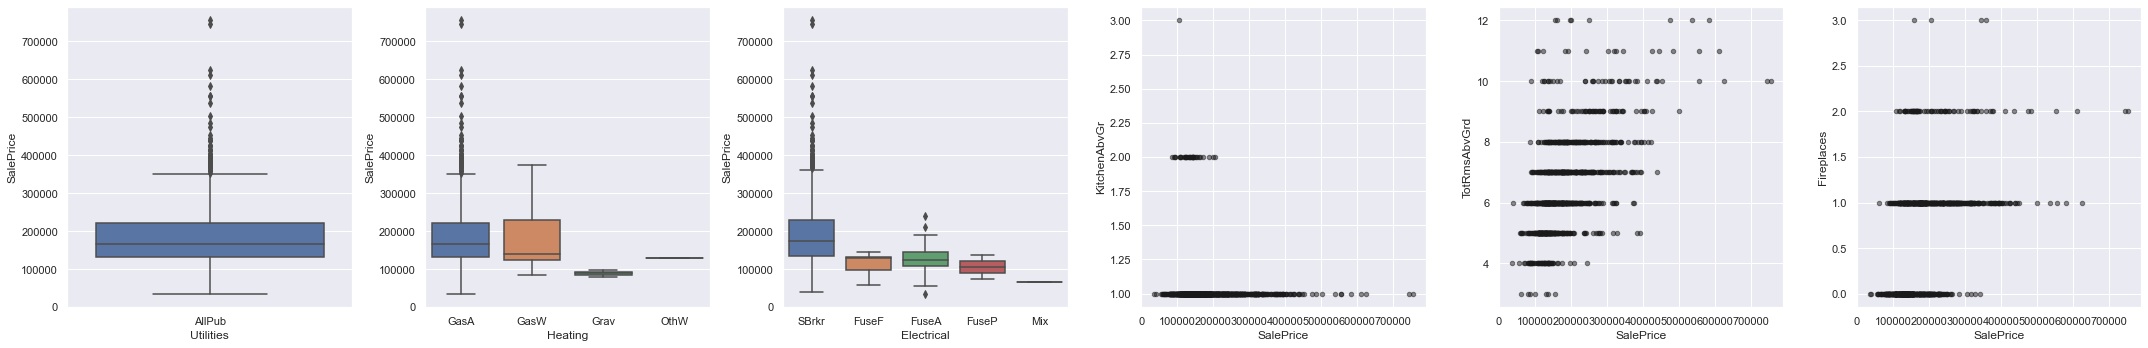

In [555]:
# Appliances : 

columns = [['SalePrice','Utilities'],['SalePrice','Heating'],['SalePrice','Electrical'],\
          ['SalePrice','KitchenAbvGr'], ['SalePrice','TotRmsAbvGrd'],['SalePrice','Fireplaces']]



plot(house_df,columns)

#### APPLIANCES : (Key Features)

Electrical seems to bre pretty correlated with SalePrice. Standard Circuit seems to be the most common, anything else from fuze box to wiring (poor etc) seems to deplete in value. 

Total Rooms Above Ground as well as Fire Places tend to increase in price as the number is increase. Kitchens above ground seems to deplete which is interesting, but maybe its an apartment or condo where more then one family lives. 


In [556]:
key_features =  ['Neighborhood','LotArea','RoofMatl','TotalBsmtSF','Foundation','GarageCars','GarageArea','GarageType','GarageYrBlt','Fireplaces',\
                'TotRmsAbvGrd','Electrical']

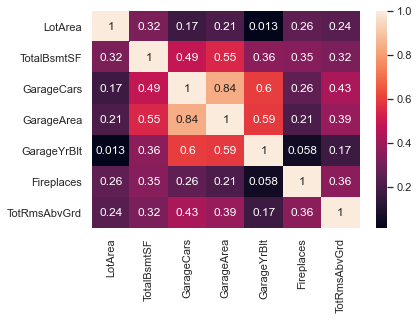

In [557]:
x = house_df[key_features].corr()

# They seem to have a good correlation with each other 
sns.heatmap(x, annot = True)

# Garage Area and Garage Cars def have a big correlation towards each other. We could remove it.

key_features =  ['Neighborhood','LotArea','RoofMatl','TotalBsmtSF','Foundation','GarageArea','GarageType','GarageYrBlt','Fireplaces',\
                'TotRmsAbvGrd','Electrical']

In [558]:
cat_list

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

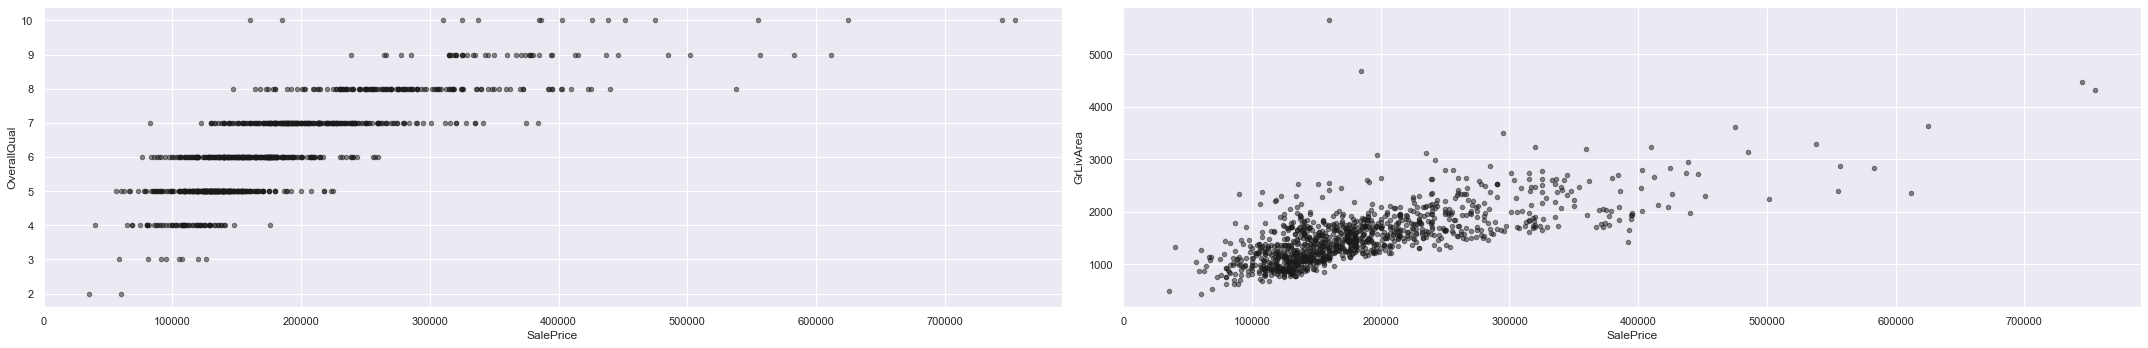

In [559]:
# RATING: 

columns = [['SalePrice','OverallQual'],['SalePrice','GrLivArea']]
plot(house_df,columns)

<AxesSubplot:>

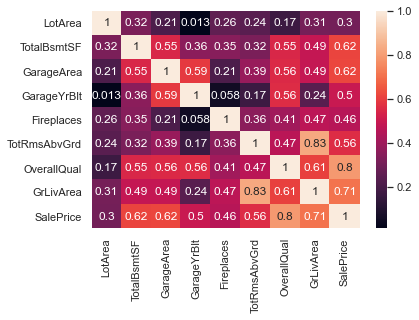

In [560]:
key_features =  ['Neighborhood','LotArea','RoofMatl','TotalBsmtSF','Foundation','GarageArea','GarageType','GarageYrBlt','Fireplaces',\
                'TotRmsAbvGrd','Electrical','HeatingQC', 'BsmtQual','ExterQual','KitchenQual','OverallQual','GrLivArea','SalePrice']

x = house_df[key_features].corr()
sns.heatmap(x, annot = True)

In [561]:
house_df[key_features].describe(include = 'all' )

,Neighborhood,LotArea,RoofMatl,TotalBsmtSF,Foundation,GarageArea,GarageType,GarageYrBlt,Fireplaces,TotRmsAbvGrd,Electrical,HeatingQC,BsmtQual,ExterQual,KitchenQual,OverallQual,GrLivArea,SalePrice
count,1094,1094.000000,1094,1094.000000,1094,1094.000000,1094,1094.000000,1094.000000,1094.000000,1094,1094,1094,1094,1094,1094.000000,1094.000000,1094.000000
unique,25,NaN,7,NaN,5,NaN,6,NaN,NaN,NaN,5,5,4,4,4,NaN,NaN,NaN
top,NAmes,NaN,CompShg,NaN,PConc,NaN,Attchd,NaN,NaN,NaN,SBrkr,Ex,TA,TA,TA,NaN,NaN,NaN
freq,173,NaN,1078,NaN,518,NaN,680,NaN,NaN,NaN,1009,594,486,646,528,NaN,NaN,NaN
mean,NaN,10132.346435,NaN,1099.561243,NaN,503.760512,NaN,1978.565814,0.610603,6.570384,NaN,NaN,NaN,NaN,NaN,6.247715,1535.027422,187033.263254
std,NaN,8212.249621,NaN,415.851262,NaN,192.261314,NaN,25.934444,0.633118,1.584486,NaN,NaN,NaN,NaN,NaN,1.366797,526.124028,83165.332151
min,NaN,1300.000000,NaN,105.000000,NaN,160.000000,NaN,1900.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,NaN,2.000000,438.000000,35311.000000
25%,NaN,7606.750000,NaN,816.000000,NaN,360.000000,NaN,1960.000000,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,5.000000,1164.000000,132500.000000
50%,NaN,9444.500000,NaN,1023.000000,NaN,484.000000,NaN,1982.000000,1.000000,6.000000,NaN,NaN,NaN,NaN,NaN,6.000000,1480.000000,165750.000000
75%,NaN,11387.250000,NaN,1345.500000,NaN,602.500000,NaN,2003.000000,1.000000,7.000000,NaN,NaN,NaN,NaN,NaN,7.000000,1779.000000,221000.000000


C:\Users\nhaus\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LotArea', ylabel='Density'>

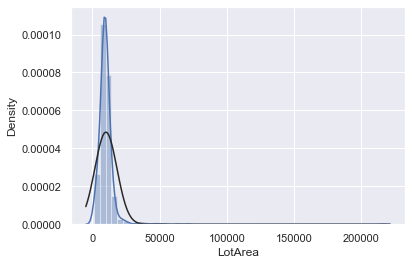

In [562]:
sns.distplot(house_df['LotArea'], fit=norm)

C:\Users\nhaus\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LotArea', ylabel='Density'>

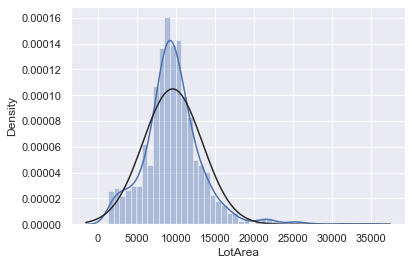

In [563]:
def removing_outliers(df, columns):
    import pickle
    for i in columns:
        q = df[i].quantile(0.99)
        df = df[df[i]<q]

    return df

house_df = removing_outliers(house_df,['LotArea'])
sns.distplot(house_df['LotArea'], fit=norm)

In [564]:
Features = ['Neighborhood','LotArea','RoofMatl','TotalBsmtSF','Foundation','GarageArea','GarageType','GarageYrBlt','Fireplaces',\
            'TotRmsAbvGrd','Electrical','HeatingQC', 'BsmtQual','ExterQual','KitchenQual','OverallQual','GrLivArea']



In [565]:
df_clean = house_df.drop(['SalePrice'], axis = 1) # We do not need this anymore, we have LogSalePrice
Target = df_clean['Log SalePrice']
df_clean = df_clean[Features]

In [566]:
df_clean.head()

,Neighborhood,LotArea,RoofMatl,TotalBsmtSF,Foundation,GarageArea,GarageType,GarageYrBlt,Fireplaces,TotRmsAbvGrd,Electrical,HeatingQC,BsmtQual,ExterQual,KitchenQual,OverallQual,GrLivArea
0,CollgCr,8450,CompShg,856,PConc,548,Attchd,2003.0,0,8,SBrkr,Ex,Gd,Gd,Gd,7,1710
1,Veenker,9600,CompShg,1262,CBlock,460,Attchd,1976.0,1,6,SBrkr,Ex,Gd,TA,TA,6,1262
2,CollgCr,11250,CompShg,920,PConc,608,Attchd,2001.0,1,6,SBrkr,Ex,Gd,Gd,Gd,7,1786
3,Crawfor,9550,CompShg,756,BrkTil,642,Detchd,1998.0,1,7,SBrkr,Gd,TA,TA,Gd,7,1717
4,NoRidge,14260,CompShg,1145,PConc,836,Attchd,2000.0,1,9,SBrkr,Ex,Gd,Gd,Gd,8,2198


#### DUMMYIFYING VARIABLES

In [567]:
# Lets map ExterQual, Kitchen Qual , BsmtQual and Heating QC : 

df_clean.HeatingQC = df_clean.HeatingQC.map({'TA' : 1, 'Fa': 0,'Ex':3,'Gd':2})
df_clean.ExterQual = df_clean.ExterQual.map({'TA' : 1, 'Fa': 0,'Ex':3,'Gd':2})
df_clean.KitchenQual = df_clean.KitchenQual.map({'TA' : 1, 'Fa': 0,'Ex':3,'Gd':2})
df_clean.BsmtQual = df_clean.BsmtQual.map({'TA' : 1, 'Fa': 0,'Ex':3,'Gd':2})

df_clean.head()


,Neighborhood,LotArea,RoofMatl,TotalBsmtSF,Foundation,GarageArea,GarageType,GarageYrBlt,Fireplaces,TotRmsAbvGrd,Electrical,HeatingQC,BsmtQual,ExterQual,KitchenQual,OverallQual,GrLivArea
0,CollgCr,8450,CompShg,856,PConc,548,Attchd,2003.0,0,8,SBrkr,3.0,2,2,2,7,1710
1,Veenker,9600,CompShg,1262,CBlock,460,Attchd,1976.0,1,6,SBrkr,3.0,2,1,1,6,1262
2,CollgCr,11250,CompShg,920,PConc,608,Attchd,2001.0,1,6,SBrkr,3.0,2,2,2,7,1786
3,Crawfor,9550,CompShg,756,BrkTil,642,Detchd,1998.0,1,7,SBrkr,2.0,1,1,2,7,1717
4,NoRidge,14260,CompShg,1145,PConc,836,Attchd,2000.0,1,9,SBrkr,3.0,2,2,2,8,2198


In [568]:
df_clean.HeatingQC = df_clean.HeatingQC.fillna(0)
df_clean.isnull().sum()

Neighborhood    0
LotArea         0
RoofMatl        0
TotalBsmtSF     0
Foundation      0
GarageArea      0
GarageType      0
GarageYrBlt     0
Fireplaces      0
TotRmsAbvGrd    0
Electrical      0
HeatingQC       0
BsmtQual        0
ExterQual       0
KitchenQual     0
OverallQual     0
GrLivArea       0
dtype: int64

In [569]:
df_dummies = pd.get_dummies(df_clean,drop_first=True)
df_dummies.head()
# This added 36 collumns. 

,LotArea,TotalBsmtSF,GarageArea,GarageYrBlt,Fireplaces,TotRmsAbvGrd,HeatingQC,BsmtQual,ExterQual,KitchenQual,...,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
0,8450,856,548,2003.0,0,8,3.0,2,2,2,...,0,1,0,0,0,0,0,0,0,1
1,9600,1262,460,1976.0,1,6,3.0,2,1,1,...,0,1,0,0,0,0,0,0,0,1
2,11250,920,608,2001.0,1,6,3.0,2,2,2,...,0,1,0,0,0,0,0,0,0,1
3,9550,756,642,1998.0,1,7,2.0,1,1,2,...,0,0,0,0,0,1,0,0,0,1
4,14260,1145,836,2000.0,1,9,3.0,2,2,2,...,0,1,0,0,0,0,0,0,0,1


In [570]:
# Lets check for MULTICOLLINNEARITY
from statsmodels.stats.outliers_influence import variance_inflation_factor # import VIF
variables = df_clean[['LotArea','TotalBsmtSF','GarageArea','GarageYrBlt','Fireplaces','TotRmsAbvGrd',\
                      'GrLivArea','OverallQual']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif



,VIF,features
0,9.813451,LotArea
1,15.743933,TotalBsmtSF
2,13.762087,GarageArea
3,39.392524,GarageYrBlt
4,2.702726,Fireplaces
5,62.650498,TotRmsAbvGrd
6,46.770280,GrLivArea
7,48.928875,OverallQual


# LINEAR REGRESSION

**TRAINING**

In [571]:
# LETS MODEL 

targets = house_df['Log SalePrice']
inputs = df_dummies

In [749]:
# Scale the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
input_scaled = scaler.transform(inputs)

In [573]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_scaled, targets, test_size =0.2 , random_state = 365)


In [574]:
# CREATE THE REGRESSION
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

Text(0, 0.5, 'Predictions (y_hat)')

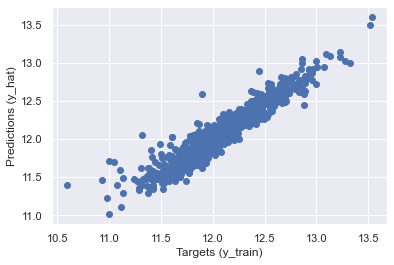

In [575]:
y_pred = reg.predict(x_train)
plt.scatter(y_train, y_pred)
plt.xlabel('Targets (y_train)')
plt.ylabel('Predictions (y_hat)')


C:\Users\nhaus\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


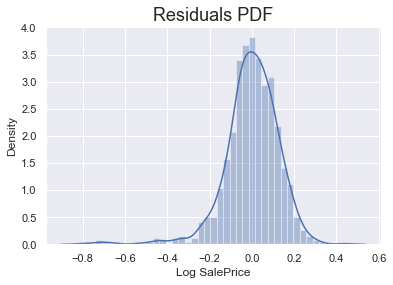

In [576]:
sns.distplot(y_train - y_hat)
plt.title("Residuals PDF", size = 18);

In [577]:
r2_score(y_pred,y_train)

0.8808910337204059

**Testing**

Text(0, 0.5, 'Predictions (y_hat_test)')

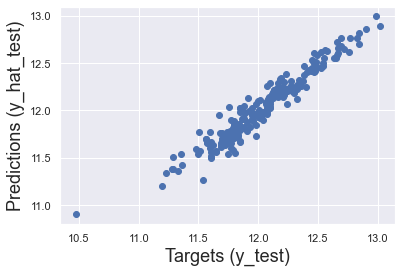

In [578]:
reg = LinearRegression()
reg.fit(x_test,y_test)
y_pred_test = reg.predict(x_test)
plt.scatter(y_test, y_pred_test, alpha = 1)
plt.xlabel('Targets (y_test)', size = 18)
plt.ylabel('Predictions (y_hat_test)', size = 18)

In [579]:
df_pf = pd.DataFrame(np.exp(y_pred_test), columns = ['Prediction'])
df_pf.head()

,Prediction
0,135273.059995
1,385888.057714
2,157765.310580
3,224941.011851
4,175113.740759


In [582]:
y_test = y_test.reset_index(drop = True)
df_pf['Target'] = np.exp(y_test)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction'] #OLS FRAMEWORK minimizes SSE
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
35,245500.000000,245500.0,0.000000e+00,0.000000e+00
22,137000.000000,137000.0,0.000000e+00,0.000000e+00
155,137000.000000,137000.0,0.000000e+00,0.000000e+00
145,73000.000000,73000.0,0.000000e+00,0.000000e+00
47,124000.000000,124000.0,2.182787e-10,1.760312e-13
...,...,...,...,...
21,100064.848851,79900.0,-2.016485e+04,2.523761e+01
27,129186.999507,99500.0,-2.968700e+04,2.983618e+01
83,168104.796078,127500.0,-4.060480e+04,3.184690e+01
34,154776.549452,117000.0,-3.777655e+04,3.228765e+01


In [583]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,217.000000,217.000000,217.000000,217.000000
mean,179569.654937,180307.442396,737.787459,7.555367
std,68829.421786,71323.789856,16392.788122,7.010304
min,54498.573279,35311.000000,-40604.796078,0.000000
25%,125962.095502,130500.000000,-9355.248457,2.835709
50%,164078.259094,163000.000000,245.862751,6.192639
75%,209356.275321,213000.000000,10527.485843,9.668325
max,438948.595583,451950.000000,53144.529308,54.338799


In [600]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_gamma_deviance

score = cross_val_score(reg,inputs,targets,cv=KFold(10, shuffle=True))
print('Cross Val Score:', score.mean())
gamma = mean_gamma_deviance(y_test,y_pred_test)
print('Mean Gamma Deviance:', gamma)

Cross Val Score: 0.8782565637265709
Mean Gamma Deviance: 7.068292897199109e-05


# RANDOM FOREST

In [731]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [742]:
x_train, x_test, y_train, y_test = train_test_split(input_scaled, targets)

MAX_DEPTH
---------

(0.19185941144836732, 5)


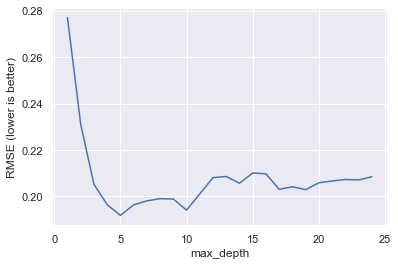

In [743]:
max_depth_range = range(1, 25)
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, inputs, targets, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

print('MAX_DEPTH')
print('---------')
print()
print(sorted(zip(RMSE_scores, max_depth_range))[0])
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [750]:
rfreg = RandomForestRegressor(max_depth = None, oob_score = True)
rfreg.fit(x_train,y_train)
scores = cross_val_score(rfreg,inputs, targets, cv=10, scoring='neg_mean_squared_error')
print('Original RMSE:', np.mean(np.sqrt(-scores)))
rfreg.oob_score_

Original RMSE: 0.14796040982417308


0.8427782553030997

In [745]:
# Lets look at feature importance

pd.DataFrame({'feature':df_dummies.columns,
              'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending = False).head(10)

,feature,importance
10,OverallQual,0.606529
11,GrLivArea,0.128179
1,TotalBsmtSF,0.075860
2,GarageArea,0.054780
3,GarageYrBlt,0.025423
0,LotArea,0.021732
7,BsmtQual,0.015732
4,Fireplaces,0.009033
28,Neighborhood_OldTown,0.008117
5,TotRmsAbvGrd,0.007607


In [746]:
inputs_new = ['OverallQual','GrLivArea','TotalBsmtSF','GarageArea','GarageYrBlt','LotArea','BsmtQual',]

In [756]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_dummies[inputs_new])
input_scaled = scaler.transform(df_dummies[inputs_new])
X_train, X_test, Y_train, Y_test = train_test_split(input_scaled, targets)
rfreg = RandomForestRegressor(max_depth = None, oob_score = True,)
rfreg.fit(X_train,Y_train)
print('TRAIN OOB R^2:', (train.oob_score_))

TRAIN OOB R^2: 0.8305069126771201


In [757]:
rfreg = RandomForestRegressor(max_depth = None, oob_score = True,max_features='auto')
rfreg.fit(X_test,Y_test)
print('TEST OOB R^2:', (rfreg.oob_score_)) 
scores = cross_val_score(rfreg, input_scaled, targets, cv=10, scoring='neg_mean_squared_error')
print('New RMSE:', np.mean(np.sqrt(-scores)))

# MY RMSE Increase by a little bit. 

TEST OOB R^2: 0.8037232098229755
New RMSE: 0.15781306587444485


### CONCLUSION 

Two things, I exhausted the data in a way that it will fit the linear regression method. I created multiple dummy variables which also seemed to somewhat impact the data a lot with multiple types of multicollineary. If i were to go further , I would use the VIF method.

My Linear Regression model seemed to do much better then my Random Forest Model. I got a R-squared for Linear Regression around 88 for both my training sets and testing sets. I am pretty happy about that. 

My Random Forest seemed to be impacted due to a high range of overfitting and too many features probably.  My R-squared revolved highly around the low 80s. In fact removing low importance features did not help my model much. 

Based off my exhaustive data breakdown, I would say Linear Regression was better. I focused mainly on correlation which probebly helped the model out a lot. Maybe next time i can focus more on variation and important features.

